# 2 point correlation function (2PCF)
### This code compute the two point correlation function of series of points embedded into space and store in GeoPandaDataFrame format.
### I- Compute the 2PCF for random point
### II- Compute  the 2PCF for the system of interest
### III- Fit the 2PCF to find the gamma of the Soneira-Peebles model

In [98]:
import sklearn.cluster as sk
import itertools
import sys
import matplotlib.pyplot as plt
from kneed import KneeLocator
from sklearn.metrics import silhouette_score
from pathlib import Path
import geopandas as gpd
path = Path().cwd().parent / "src" #to add the src directory to the path regognized by Python
sys.path.append(str(path))
import methods_two_point_correlation as mtpc
import save_load_pickle as slp
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.optimize import curve_fit
import sklearn.cluster as sk
from sklearn.metrics import silhouette_score
# Bookkeeping of important path in the project
data_dir = Path().cwd().parent/Path("data")
data_city = data_dir / "cities"
data_map = data_dir / "map"
out_dir = Path().cwd().parent/Path("out")
plot_dir = out_dir / Path("plot")

## Parameters

In [99]:
name = "Belgium" #name of the system considered
name_random = f"Random{name}" #How the name of the random catalo will be saved
threshold = 1 # minimal number of inhabitants for the city to be considered
N_run = 5 # number of random catalog generated for computing the 2PCF
size = 7000 #number of points each random catalog has
k = 3  #number of time the 2PCF computing process is repeated to estimate variance
rmax = None#1e5 #maximal distance between two points considered, if None, taken the max from data
scale = "log" #scale at which to bin the data, recommended "log"
nbins = 20 # number of bins to consider in the computation of 2PCF (betweem rmin and rmax)

In [100]:
##Preprocessing
crs = mtpc.crs_selector(name) # Coordinate reference system of the country considered
path_city = data_city / f"{name}_cities.csv" #Path of the cities 
path_border = data_map / f"{name}.geojson" # Path of the multipolygon of the territory of the country
gdf_city = mtpc.load_df_to_gdf(path_city,threshold) # Geopandas of the dataset
gdf_edge = gpd.read_file(path_border) #Geopandas of the polygon border of the dataset
gdf_projected = gdf_city.to_crs(crs) # Projection in the right coordinate system
coord = gdf_projected.get_coordinates() # Coordinates of the points in dataset

In [101]:
crs

'EPSG:3812'

## 2PCF for random point
### Evaluation of the 2PCF requires one or several catalog of random points that fit
### the surface on which the spatial points lies.
### Here we check that the 2PCF of random point is around zero at all scale to ensure there are no biases for the real system at the parameters we consider

In [102]:
##Create directories and path to save data
path_save_random = out_dir/Path("2pcf_random") /Path(f"{name_random}/")
path_save_random.mkdir(parents=True,exist_ok=True)

In [103]:
name_save_random = path_save_random/Path(f"{threshold}_{N_run}_{size}_{k}_{rmax}_{scale}_{nbins}")
# pay attention to waht each number means 
gdf_projected_random= mtpc.generate_random_point(gdf_edge,len(gdf_city),crs,check_gpd=True)
r_edges,l_xi = mtpc.PCF_with_variance(gdf_projected_random,gdf_edge,crs,N_run,size,k,rmax,scale,nbins=nbins)
distance_distribution = mtpc.compute_DD(gdf_projected_random)
#store the random test
d_save = {}
d_save["r_edges"] = r_edges
d_save["xi"] = l_xi
d_save["distance_distribution"] = distance_distribution
slp.save_results(name_save_random,d_save)

0
1
2
3
max DD 284019
rmin,rmax= 3135.031863275429 284020
normalization DD  1.0
normalization DR  0.9999985365853659
normalization RR  0.99999792623436
0
1
2
3
max DD 284019
rmin,rmax= 3135.031863275429 284020
normalization DD  1.0
normalization DR  0.9999984668989547
normalization RR  0.9999981221807197
0
1
2
3
max DD 284019
rmin,rmax= 3135.031863275429 284020
normalization DD  1.0
normalization DR  0.9999980487804878
normalization RR  0.9999974608617558


<Axes: >

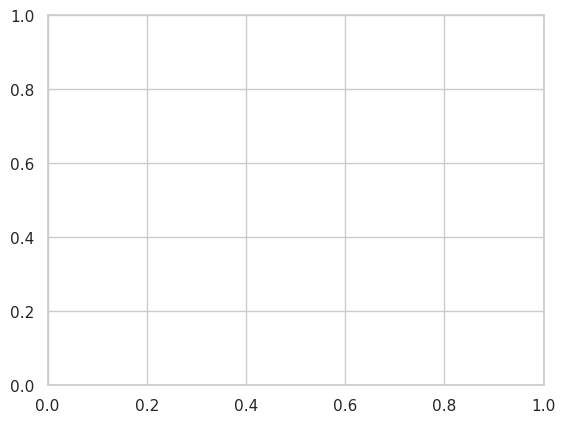

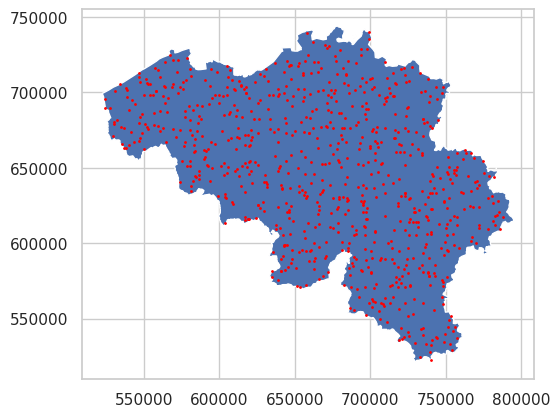

In [104]:
fig, ax = plt.subplots()
ax=gdf_edge.to_crs(crs).plot()
gdf_projected_random.plot(ax=ax,color="red",markersize=1)

In [105]:
def plot_2pcf(load_file,scale):
    """Plot and save the 2pcf store in load_file"""
    i=1
    name = load_file.parent.name
    fig, ax = plt.subplots()
    sns.set(style="whitegrid")
    d = slp.load_results(load_file)
    r_edges, l_xi = d["r_edges"],d["xi"]
    xi = np.mean(l_xi,axis=0)
    error = np.std(l_xi,axis=0)
    if len(xi) != len(r_edges): #when we choose a rmax define by user the code put an extra category above
        xi = xi[0:-1]
        error = error[0:-1]
    color = sns.color_palette("viridis")[0]
    r_edges = r_edges[1:]
    xi = xi[1:]
    error = error[1:]
    end = np.zeros([1])
    end[0] = 1.1*r_edges[-1]
    r_edges_zero = np.concatenate((r_edges,end))
    width = np.diff(r_edges_zero) #need to find a way to encode properly the first alignement
    ax.bar(r_edges,xi,width=width,align="center",edgecolor="black",color=color,alpha=0.5)
    plt.errorbar(r_edges, xi, yerr=error, fmt="o", color="r",ms=1)
    title = "2 points correlation function "+name
    plt.title(title)
    plt.ylabel(r"$\xi(r)$")
    plt.xlabel(r"$r$ (meters)")
    if scale == "lin":
        plt.xscale("linear")
    else:
        plt.xscale(scale)
    #plt.yscale("log")
    #plt.legend()
    plt.savefig(plot_dir / title, format="png",transparent=True)
    plt.show()

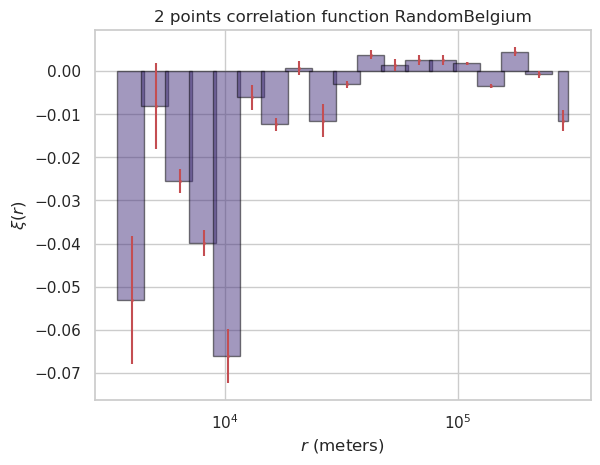

In [106]:
plot_2pcf(name_save_random,scale)

## 2PCF for the dataset

In [107]:
##Create directories and path to save data
path_save = out_dir /Path("2pcf") /Path(f"{name}/")
path_save.mkdir(parents=True,exist_ok=True)

In [108]:
name_save = path_save/Path(f"{threshold}_{N_run}_{size}_{k}__{rmax}_{scale}_{nbins}")
r_edges,l_xi = mtpc.PCF_with_variance(gdf_projected,gdf_edge,crs,N_run,size,k,rmax,scale,nbins=nbins)
distance_distribution = mtpc.compute_DD(gdf_projected)
#Store the 2pcf for the system under consideration
d_save = {}
d_save["r_edges"] = r_edges
d_save["xi"] = l_xi
d_save["distance_distribution"] = distance_distribution
slp.save_results(name_save,d_save)

0
1
2
3
max DD 287895
rmin,rmax= 3579.201070238496 287896
normalization DD  1.0
normalization DR  0.999999756097561
normalization RR  0.9999999428489784
0
1
2
3
max DD 287895
rmin,rmax= 3579.201070238496 287896
normalization DD  1.0
normalization DR  0.9999997909407665
normalization RR  0.9999999428489784
0
1
2
3
max DD 287895
rmin,rmax= 3579.201070238496 287896
normalization DD  1.0
normalization DR  0.9999996515679442
normalization RR  0.9999999346845467


<Axes: >

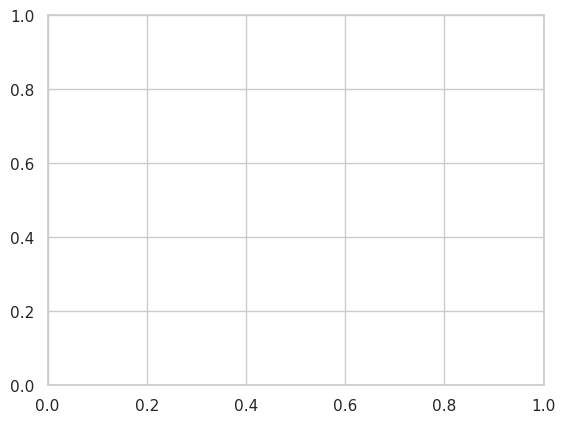

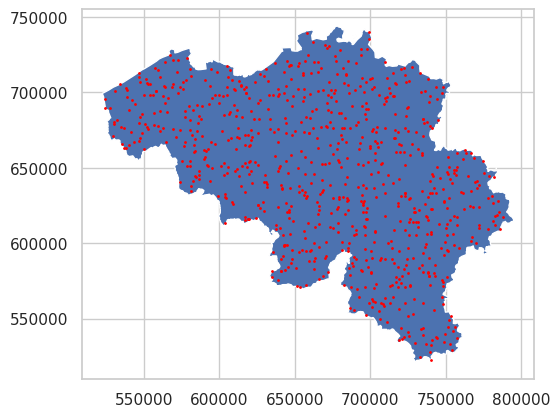

In [109]:
fig, ax = plt.subplots()
ax=gdf_edge.to_crs(crs).plot()
gdf_projected_random.plot(ax=ax,color="red",markersize=1)

In [110]:
distance_distribution[0]

41419

In [111]:
gdf_city.head()

,Unnamed: 0,city,city_ascii,city_alt,lat,lng,country,iso2,iso3,admin_name,admin_name_ascii,admin_code,admin_type,capital,density,population,population_proper,ranking,timezone,same_name,id,geometry
0,1769739,Brussels,Brussels,Bruxelles|Brussel|Brüssel,50.8467,4.3525,Belgium,BE,BEL,Brussels-Capital Region,Brussels-Capital Region,BE-BRU,region,primary,7465.2,1235192.0,1235192.0,1,Europe/Brussels,False,1056469830,POINT (4.3525 50.8467)
1,1769740,Antwerp,Antwerp,Anvers|Antwerpen,51.2178,4.4003,Belgium,BE,BEL,Flanders,Flanders,BE-VLG,region,minor,2600.0,536079.0,536079.0,2,Europe/Brussels,False,1056168623,POINT (4.4003 51.2178)
2,1769741,Gent,Gent,Gand|Ghent,51.0536,3.7253,Belgium,BE,BEL,Flanders,Flanders,BE-VLG,region,minor,1680.2,265086.0,265086.0,2,Europe/Brussels,False,1056062897,POINT (3.7253 51.0536)
3,1769742,Charleroi,Charleroi,NaN,50.4000,4.4333,Belgium,BE,BEL,Wallonia,Wallonia,BE-WAL,region,minor,1977.0,201816.0,201816.0,2,Europe/Brussels,False,1056263311,POINT (4.4333 50.4)
4,1769743,Liège,Liege,Lige|Lüttich|Leodicum|Luik,50.6397,5.5706,Belgium,BE,BEL,Wallonia,Wallonia,BE-WAL,region,minor,2844.5,195278.0,195278.0,2,Europe/Brussels,False,1056513284,POINT (5.5706 50.6397)


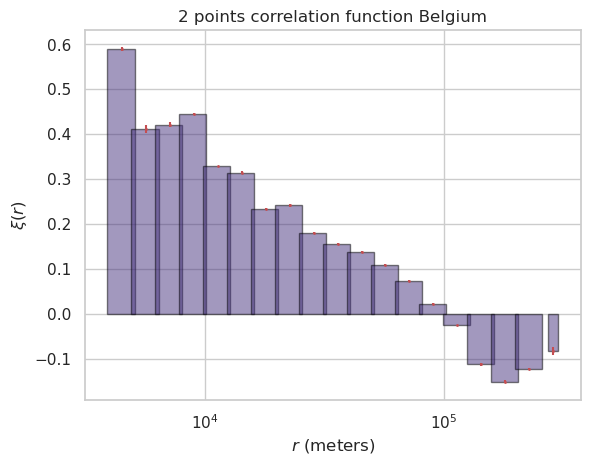

In [112]:
plot_2pcf(name_save,scale)

In [113]:
len(gdf_city)

820

In [114]:
index_zero =np.where(np.mean(l_xi,axis=0) <0)[0]

## Fit the 2PCF to find the gamma of the Soneira-Peebles model

In [115]:
def power_law(r, gamma,r0):
    """The power law form of the SP model"""
    model = (r/r0)**(-gamma)
    return model

a,b = 1,19 #the two extremal index between which fitting the SP"
xi = np.mean(l_xi,axis=0)
error = np.std(l_xi,axis=0) #vertical error due to statistical variance
xi_reduced = xi[a:b]
r_reduced = r_edges[a:b]
error_reduced = error[a:b]
popt,pcov = curve_fit(power_law,r_reduced,xi_reduced,sigma=error_reduced)
# popt[0] is fitted gamma, popt[1] is fitted r0
#pcov is the covariance matrix
d_save = {}
d_save["r_edges"] = r_edges
d_save["xi"] = l_xi
d_save["distance_distribution"] = distance_distribution
d_save["fit_SP"] = popt
d_save["covariance_fit"] = pcov
d_save["number_points"] = len(gdf_projected)
slp.save_results(name_save,d_save)

In [116]:
def plot_2pcf_with_fit(load_file,popt,pco,scale):
    """Plot and save the 2pcf of the system together with the SP fit
    The 4 curves represent several combination of parameters within 1-sigma of the parameters
    """
    i=1
    name = load_file.parent.name
    fig, ax = plt.subplots()
    sns.set(style="whitegrid")
    d = slp.load_results(load_file)
    r_edges, l_xi = d["r_edges"],d["xi"]
    xi = np.mean(l_xi,axis=0)
    error = np.std(l_xi,axis=0)
    color = sns.color_palette("viridis")[0]
    r_edges = r_edges#[1:]
    xi = xi#[1:]
    error = error#[1:]
    if len(xi) != len(r_edges): #when we choose a rmax define by user the code put an extra category above
        xi = xi[0:-1]
        error = error[0:-1]
    end = np.zeros([1])
    end[0] = 1.1*r_edges[-1]
    r_edges_zero = np.concatenate((r_edges,end))
    width = np.diff(r_edges_zero) #need to find a way to encode properly the first alignement
    ax.bar(r_edges,xi,width=width,align="center",edgecolor="black",color=color,alpha=0.5)
    plt.errorbar(r_edges, xi, yerr=error, fmt="o", color="r",ms=1)
    delta_gamma,delta_r0=np.sqrt(np.diag(pcov))
    popt1 = [popt[0]+delta_gamma,popt[1]+delta_r0]
    popt2 = [popt[0]-delta_gamma,popt[1]-delta_r0]
    popt3 = [popt[0]+delta_gamma,popt[1]-delta_r0]
    popt4 = [popt[0]-delta_gamma,popt[1]+delta_r0]
    plt.plot(r_edges, power_law(r_edges, *popt), '--',label=f"$\gamma={np.round(popt[0],3)} +- {np.round(delta_gamma,3)},r_0={np.round(popt[1],0)} +- {np.round(delta_r0,0)}$")
    plt.plot(r_edges, power_law(r_edges, *popt1), '--',color="red")
    plt.plot(r_edges, power_law(r_edges, *popt2), '--',color="orange")
    plt.plot(r_edges, power_law(r_edges, *popt3), '--',color="green")
    plt.plot(r_edges, power_law(r_edges, *popt4), '--',color="purple")
    #print(popt2)
    title = "Fit 2 points correlation function "+name
    plt.title(title)
    plt.ylabel(r"$\xi(r)$")
    plt.xlabel(r"$r$ (meters)")
    if scale == "lin":
        plt.xscale("linear")
    else:
        plt.xscale("log")
    plt.yscale("log")
    plt.legend()
    plt.savefig( plot_dir / title, format="png",transparent=True)
    plt.show()

In [117]:
popt

array([8.49118842e-01, 3.05352417e+03])

In [118]:
np.sqrt(np.diag(pcov)) #standard deviation of the 2 parameters

array([1.12911667e-01, 5.84228411e+02])

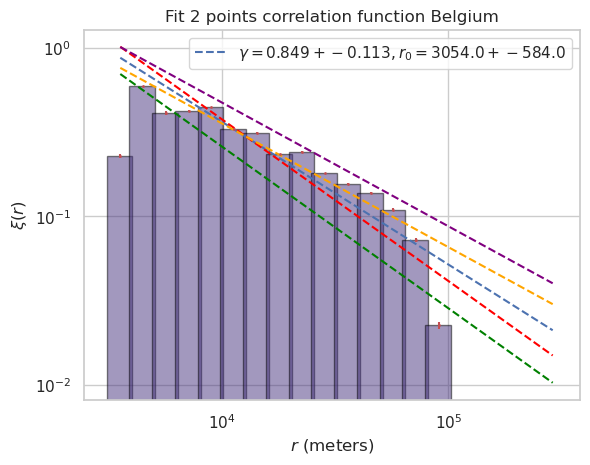

In [119]:
plot_2pcf_with_fit(name_save,popt,pcov,scale)

## Estimate the number of subclusters from data
## Here we make the assumption that the subclusters do not overlap too much so that the silhouette score can
## distinguish them, we retain the 4 most probables cluster to be tested

In [120]:
#Here we use the silhouette score to asess what is the most relevant paraemters eta to test in the SP 
#model, since teh KMeans clusetring is hierarichcal for each k we select the best clustering over n_init
#runß

coord = gdf_projected.get_coordinates()
kmax = 20 # maximum number of cluster to consider 
l_silhouette = []
silhouette_coefficients = []
for k in range(2, kmax):
    kmeans = sk.KMeans(n_clusters=k,tol=1e-8,max_iter=1000,n_init=100).fit(coord)
    score = silhouette_score(coord, kmeans.labels_)
    silhouette_coefficients.append(score)
l_silhouette.append(silhouette_coefficients)

In [121]:
def plot_silhouette(kmax,l_silhouette):
    """Plot and save the silhouette plot"""
    fig, ax = plt.subplots(figsize=(10,10))
    plt.style.use("fivethirtyeight")
    plt.plot(range(2, kmax), np.mean(l_silhouette,axis=0))
    plt.errorbar(range(2, kmax), np.mean(l_silhouette,axis=0), yerr=np.std(l_silhouette,axis=0), fmt="o", color="r",ms=5)
    plt.xticks(range(2, kmax))
    plt.xlabel("Number of Clusters")
    plt.ylabel("Silhouette Coefficient")
    ax.set_aspect(1. / ax.get_data_ratio(), adjustable='box')
    #plt.savefig("kmeans_silhouette_score.png",format="png",transparent=True)
    plt.show()

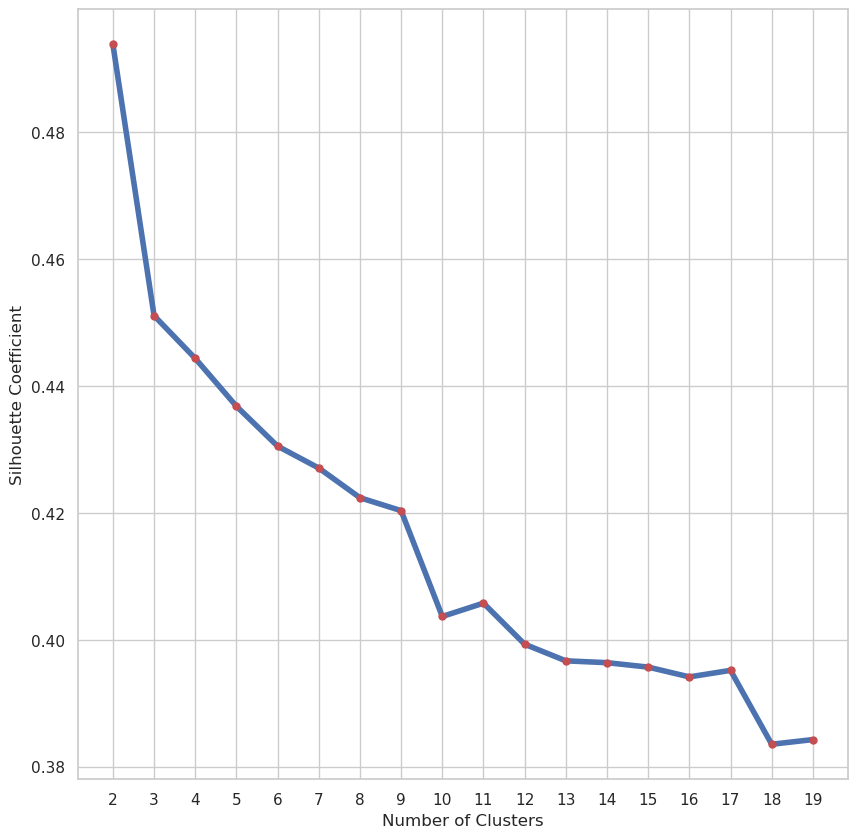

In [28]:
plot_silhouette(kmax,l_silhouette)

In [29]:
l_cluster = np.argsort(np.mean(l_silhouette,axis=0))[-5:] #we select the 4 better clustering
l_cluster = np.flip(l_cluster)+2
d_save = {} #save the final file with distance distribution,and the fit parameters
d_save["r_edges"] = r_edges
d_save["xi"] = l_xi
d_save["distance_distribution"] = distance_distribution
d_save["fit_SP"] = popt
d_save["covariance_fit"] = pcov
d_save["number_points"] = len(gdf_projected)
d_save["clustering"] = l_cluster
d_save["silhouette_score"] = l_silhouette
slp.save_results(name_save,d_save)

In [30]:
l_cluster

array([2, 3, 4, 5, 6])

In [ ]:
## For fun, compute the correlation dimension of the datasets
### in 2D, a dimension of one 2 means totally random points, a dimesion of one means totally correlated 
### points i.e. a curve,

In [31]:
from scipy.spatial import distance

In [69]:
distance_data = distance.cdist(coord,coord).astype(np.int32)

In [82]:
#coord_random = gdf_projected_random.get_coordinates().to_numpy()
#distance_data = distance.cdist(coord_random,coord_random).astype(np.int32)

In [83]:
distance_data

array([[     0,   2462,   6095, ..., 328967, 335314, 334672],
       [  2462,      0,   4902, ..., 326734, 333104, 332457],
       [  6095,   4902,      0, ..., 323473, 329767, 329136],
       ...,
       [328967, 326734, 323473, ...,      0,   9320,   7850],
       [335314, 333104, 329767, ...,   9320,      0,   1576],
       [334672, 332457, 329136, ...,   7850,   1576,      0]], dtype=int32)

In [84]:
rmin=mtpc.compute_rmin(gdf_projected)
rmax=5e4
N= np.linspace(rmin,rmax,20)
correlation_dimension = []
for n in N:
    correlation_dimension.append(len(np.where( distance_data < n)[0])/len(gdf_projected))

In [85]:
rmin=mtpc.compute_rmin(gdf_projected)
N= np.linspace(rmin,rmax,20)
correlation_dimension = []
std_corr_dim = []
N_square = len(gdf_projected)*len(gdf_projected)
for n in N:
    correlation_at_n = []
    for i in range(len(distance_data)):
        correlation_at_n.append(len(np.where( distance_data[i] < n)[0]))
    correlation_dimension.append(np.mean(correlation_at_n))
    std_corr_dim.append(np.std(correlation_at_n))

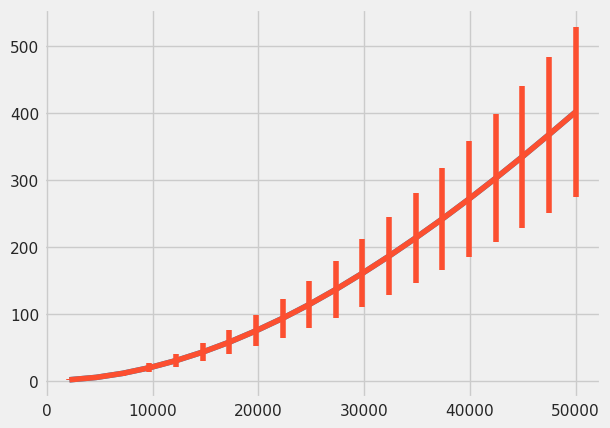

In [86]:
plt.plot(N,correlation_dimension)
plt.errorbar(N,correlation_dimension,yerr=std_corr_dim)
plt.show()

In [87]:
def power_law(r, gamma,r0):
     model = r0*(r)**(gamma)
     return model
popt,pcov = curve_fit(power_law,N,correlation_dimension,sigma=std_corr_dim)

In [88]:
popt

array([1.79892240e+00, 1.41562067e-06])

In [89]:
np.sqrt(np.diag(pcov))

array([1.78807961e-02, 2.54863387e-07])